In [32]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [34]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [35]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [36]:
tf.keras.backend.clear_session()

In [37]:
subject = 'Ceará - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [38]:
data = pd.read_csv('2003_mo_model_input_CE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Ceará - Desemprego,Ceará - Consumo de Cimento (t),Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,8.274459,81.265,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,8.268512,65.200,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,8.262564,55.165,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,8.256617,53.928,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,8.250670,65.334,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


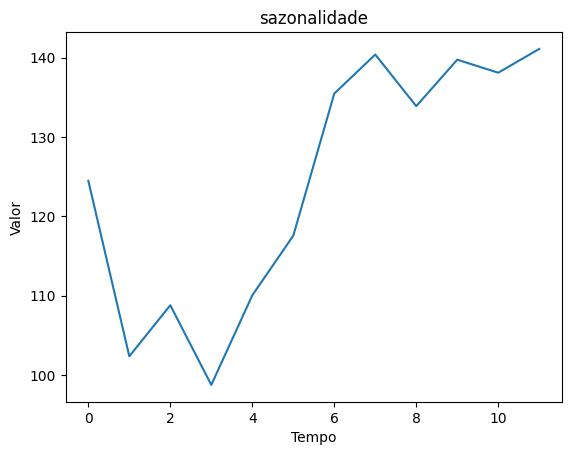

,sazonalidade
sazonalidade,
0,124.493866
1,102.368049
2,108.801990
3,98.757175
4,110.048993
5,117.570643
6,135.481610
7,140.404119
8,133.899862


In [39]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [40]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Ceará - Consumo de Cimento (t)
0,2003-1,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,124.493866,81.265
1,2003-2,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,102.368049,65.200
2,2003-3,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,108.801990,55.165
3,2003-4,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,98.757175,53.928
4,2003-5,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,110.048993,65.334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.048993,NaN
245,2023-6,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.570643,NaN
246,2023-7,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.481610,NaN
247,2023-8,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.404119,NaN


In [41]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      91.341
1      69.730
2      77.682
3      66.140
4      76.289
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Ceará - Consumo de Cimento (t), Length: 249, dtype: float64

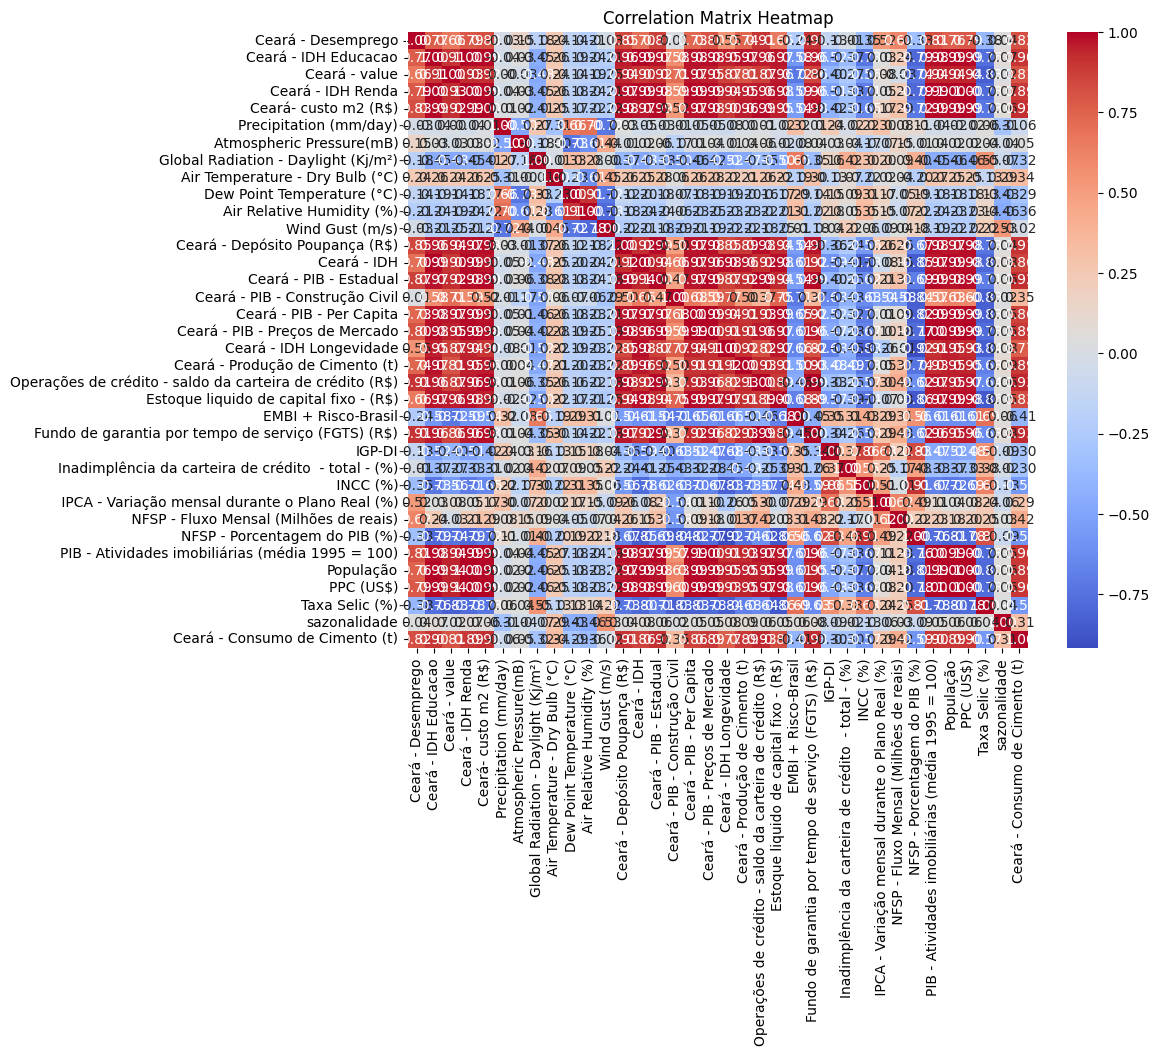

In [42]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [44]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Ceará - Desemprego,2.441732e+05
1,Ceará - IDH Educacao,2.496404e+10
2,Ceará - value,4.670776e+03
3,Ceará - IDH Renda,2.258629e+08
4,Ceará- custo m2 (R$),1.884811e+05
5,Precipitation (mm/day),1.402533e+01
6,Atmospheric Pressure(mB),2.263391e+01
7,Global Radiation - Daylight (Kj/m²),8.609562e+00
8,Air Temperature - Dry Bulb (°C),1.433972e+06
9,Dew Point Temperature (°C),8.510256e+05


In [45]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 5


,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,6.965352e+07,4.525724e+06,107.673000,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,124.493866
1,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,6.974354e+07,4.530359e+06,107.237962,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,102.368049
2,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,6.983356e+07,4.534994e+06,108.742184,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,108.801990
3,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,6.992358e+07,4.539629e+06,109.391112,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,98.757175
4,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,7.001361e+07,4.544265e+06,111.602457,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,110.048993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,11.051208,0.723485,0.345701,0.656838,21880.341463,1.259433,1010.472095,1367.387618,27.130751,20.521186,68.311835,3.061092,9.773431e+06,8.367408e+07,4.660253e+06,177.654033,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,140.404119
152,11.055607,0.724916,0.343941,0.657731,21976.873803,1.163616,1010.282290,1396.155808,27.356156,20.603287,67.740574,3.108083,9.747055e+06,8.371297e+07,4.653769e+06,179.384841,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,133.899862
153,11.060005,0.726348,0.342393,0.658625,22069.114212,1.112374,1009.954831,1394.739603,27.570604,20.893800,68.063069,2.983928,9.720680e+06,8.375186e+07,4.647286e+06,181.157579,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,139.752172
154,11.064403,0.727779,0.341552,0.659518,22162.190422,0.997120,1009.659056,1478.722339,28.001261,21.255675,67.787814,2.973341,9.694304e+06,8.379075e+07,4.640803e+06,182.836966,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,1.972040e+08,394.326420,1.038436,138.114795


In [46]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.000000,0.110899,0.000000,0.000000,0.371316,0.403687,0.180477,0.427186,0.492771,0.536124,0.737771,0.000000,0.000000,0.000000,0.005627,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.000000,0.807549
1,0.007759,0.111104,0.007777,0.007199,0.371437,0.403487,0.180477,0.427492,0.492835,0.536078,0.736986,0.003621,0.006350,0.014215,0.000000,0.000207,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.009041,0.004103,0.687691
2,0.015519,0.110066,0.015554,0.013765,0.371507,0.403371,0.180477,0.427671,0.492873,0.536051,0.736527,0.007243,0.012700,0.028430,0.019456,0.000221,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.018082,0.008337,1.000000
3,0.023278,0.105225,0.023330,0.019961,0.371514,0.403359,0.180477,0.427690,0.492877,0.536049,0.736478,0.010864,0.019051,0.042645,0.027849,0.000380,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.027123,0.012670,0.616940
4,0.031038,0.099059,0.031107,0.025865,0.467057,0.365918,0.215582,0.400703,0.559751,0.599824,0.676082,0.014486,0.025401,0.056860,0.056451,0.000881,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.036164,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.921880,0.658191,0.930024,0.968687,0.307488,0.519648,0.112469,0.457698,0.168660,0.313631,0.732878,0.886034,0.989027,0.412566,0.910769,0.980090,0.341211,0.837927,0.143160,0.305639,0.047659,0.409150,0.997036,0.057396,0.993627,0.984655,0.977394,0.411003
152,0.941410,0.636453,0.947518,0.976704,0.272456,0.495331,0.114835,0.564015,0.196567,0.282265,0.757178,0.881485,0.991770,0.392684,0.933155,0.985706,0.361289,0.836471,0.149108,0.387048,0.021964,0.403230,0.993528,0.050845,0.994471,0.988491,0.982733,0.324736
153,0.960940,0.617342,0.965012,0.984364,0.253721,0.453379,0.114719,0.665163,0.295318,0.299972,0.692974,0.876936,0.994513,0.372801,0.956084,0.991968,0.383934,0.897087,0.106917,0.471089,0.021585,0.393004,0.972085,0.043758,0.995316,0.992327,0.988182,0.456024
154,0.980470,0.606952,0.982506,0.992094,0.211583,0.415486,0.121626,0.868291,0.418325,0.284859,0.687499,0.872386,0.997257,0.352919,0.977805,0.997280,0.399650,0.964383,0.074759,0.554626,0.015452,0.356091,0.963119,0.037052,0.993880,0.996164,0.993896,0.381217


In [47]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.000000,0.110899,0.000000,0.000000,0.371316,0.403687,0.180477,0.427186,0.492771,0.536124,0.737771,0.000000,0.000000,0.000000,0.005627,0.000000,0.108706,0.016690,1.000000,0.912229,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.000000,0.807549
1,0.007759,0.111104,0.007777,0.007199,0.371437,0.403487,0.180477,0.427492,0.492835,0.536078,0.736986,0.003621,0.006350,0.014215,0.000000,0.000207,0.058377,0.005415,0.934664,0.910339,0.961590,0.898644,0.544990,0.965719,0.001830,0.009041,0.004103,0.687691
2,0.015519,0.110066,0.015554,0.013765,0.371507,0.403371,0.180477,0.427671,0.492873,0.536051,0.736527,0.007243,0.012700,0.028430,0.019456,0.000221,0.100305,0.001062,0.903684,0.909866,0.936241,0.836703,0.532585,0.927412,0.003660,0.018082,0.008337,1.000000
3,0.023278,0.105225,0.023330,0.019961,0.371514,0.403359,0.180477,0.427690,0.492877,0.536049,0.736478,0.010864,0.019051,0.042645,0.027849,0.000380,0.211591,0.000000,0.854353,0.909131,0.911951,0.809101,0.504220,0.885588,0.005490,0.027123,0.012670,0.616940
4,0.031038,0.099059,0.031107,0.025865,0.467057,0.365918,0.215582,0.400703,0.559751,0.599824,0.676082,0.014486,0.025401,0.056860,0.056451,0.000881,0.358835,0.002490,0.819481,0.905479,0.963424,0.772577,0.515509,0.838034,0.007747,0.036164,0.016889,0.788236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.770098,0.924448,0.810964,0.873389,0.253554,0.505357,0.111747,0.503161,0.077001,0.237088,0.752430,0.952095,0.950780,0.617234,0.725151,0.881396,0.145335,0.767121,0.369541,0.134802,0.160109,0.756416,0.799973,0.094876,0.999733,0.937538,0.929945,0.302580
140,0.773113,0.901748,0.810284,0.881256,0.267846,0.467218,0.114430,0.567419,0.124695,0.232897,0.800358,0.945251,0.954588,0.604136,0.744153,0.891920,0.149790,0.770809,0.373663,0.107661,0.168785,0.755278,0.803815,0.095765,0.999867,0.941590,0.932690,0.229929
141,0.776127,0.885016,0.809604,0.889017,0.345908,0.436583,0.115572,0.604685,0.155634,0.234039,0.795600,0.938408,0.958397,0.591038,0.763589,0.904492,0.156217,0.823469,0.383080,0.063009,0.169823,0.745299,0.692895,0.095412,1.000000,0.945643,0.935504,0.334488
142,0.779142,0.859530,0.808925,0.896796,0.429850,0.404351,0.111881,0.617727,0.261812,0.297106,0.715095,0.931564,0.962206,0.577940,0.783430,0.916359,0.164797,0.886163,0.372850,0.017943,0.168006,0.739572,0.764133,0.094477,0.997032,0.949695,0.938403,0.291661


In [48]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       91.341000
1       69.730000
2       77.682000
3       66.140000
4       76.289000
          ...    
139    217.512033
140    208.465083
141    215.913026
142    211.397493
143    188.896000
Name: Ceará - Consumo de Cimento (t), Length: 144, dtype: float64

In [49]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [50]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 28)

In [51]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
108,0.660560,0.866996,0.702355,0.683134,0.542426,0.256276,0.113341,0.580967,0.650947,0.578099,0.547679,0.712664,0.740744,0.932447,0.511081,0.584672,0.046476,0.576729,0.241213,0.894461,0.269958,0.246811,0.011842,0.021268,0.788736,0.799602,0.794730,0.126286
109,0.664097,0.870225,0.711426,0.688421,0.630812,0.271580,0.109735,0.522877,0.696693,0.639578,0.478773,0.726347,0.749251,0.923138,0.524694,0.592860,0.049796,0.547631,0.257717,0.933771,0.247038,0.255042,0.061730,0.022371,0.801322,0.804370,0.800825,0.136300
110,0.667635,0.873080,0.720497,0.693764,0.725411,0.322059,0.105957,0.484283,0.714249,0.671870,0.442846,0.740030,0.757757,0.913829,0.524028,0.603045,0.050154,0.547834,0.301698,0.961400,0.246383,0.284608,0.066764,0.024066,0.813907,0.809137,0.806817,0.198981
111,0.671172,0.875595,0.729567,0.699234,0.622498,0.373060,0.105465,0.451958,0.624667,0.626415,0.468946,0.753713,0.766264,0.904520,0.519685,0.613555,0.048907,0.541336,0.299812,0.983561,0.261807,0.314835,0.043925,0.025253,0.826493,0.813905,0.812425,0.124912
112,0.674710,0.880338,0.738638,0.704595,0.530221,0.452991,0.106772,0.401231,0.456407,0.539382,0.537836,0.767396,0.774770,0.895211,0.524909,0.623825,0.044925,0.547192,0.255504,0.984745,0.316206,0.306260,0.095032,0.028261,0.839666,0.818673,0.818016,0.032369
113,0.678247,0.887906,0.747708,0.709994,0.371453,0.517931,0.109663,0.373624,0.303824,0.453879,0.611831,0.781078,0.783277,0.885902,0.524323,0.633509,0.039367,0.555211,0.207948,0.987221,0.266153,0.311235,0.101029,0.031624,0.852839,0.823441,0.823761,0.039834
114,0.681784,0.899881,0.756779,0.715381,0.208235,0.515325,0.114859,0.399324,0.165589,0.349352,0.735621,0.794761,0.791784,0.876593,0.524345,0.642425,0.033811,0.557537,0.169207,0.990146,0.267539,0.309980,0.105226,0.034133,0.866013,0.828209,0.829544,0.042221
115,0.685322,0.910709,0.765850,0.720648,0.161256,0.490575,0.118891,0.454840,0.121337,0.292416,0.787774,0.808444,0.800290,0.867284,0.521003,0.652070,0.026160,0.563561,0.122054,1.000000,0.243993,0.301380,0.132974,0.034686,0.878234,0.832976,0.835366,0.092363
116,0.688859,0.916566,0.774920,0.725883,0.147874,0.423400,0.120187,0.545335,0.179727,0.284557,0.813381,0.822127,0.808797,0.857975,0.518763,0.662246,0.018514,0.562394,0.079036,0.985009,0.240073,0.312886,0.163856,0.036283,0.890455,0.837744,0.840978,0.158579
117,0.692397,0.928740,0.783991,0.731067,0.161430,0.353876,0.119818,0.631391,0.287807,0.311031,0.800705,0.835810,0.817304,0.848666,0.518339,0.675009,0.010641,0.609785,0.065481,0.946695,0.238489,0.304865,0.176276,0.036400,0.902676,0.842512,0.846397,0.091050


In [52]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 28)

In [53]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [54]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [55]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [56]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1530355883, 4034378238, 3937862308, 2442242297, 1365608388, 249726708, 4258452473, 1355069637, 3726214071, 3853249549]


Step: 0 ___________________________________________
val_loss: 109.41552734375
winner_seed: 1530355883


Step: 1 ___________________________________________
val_loss: 96.2268295288086
winner_seed: 4034378238


Step: 2 ___________________________________________
val_loss: 235.03402709960938


Step: 3 ___________________________________________
val_loss: 137.17445373535156


Step: 4 ___________________________________________
val_loss: 267.03277587890625


Step: 5 ___________________________________________
val_loss: 99.68628692626953


Step: 6 ___________________________________________
val_loss: 361.795166015625


Step: 7 ___________________________________________
val_loss: 151.98031616210938


Step: 8 ___________________________________________
val_loss: 114.58724212646484


Step: 9 ___________________________________________
val_loss: 66.70018005371094
winner_seed

In [57]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 113ms/step - loss: 22677.1426 - val_loss: 1043.0135
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 2162.3174 - val_loss: 1755.5038
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 1831.7329 - val_loss: 1165.9728
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 2013.9630 - val_loss: 2448.0640
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 1812.7109 - val_loss: 2618.7993
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 1813.0391 - val_loss: 1275.8389
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 1936.2627 - val_loss: 3241.6077
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 1835.0051 - val_loss: 4005.8333
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 2013.2712 - val_loss: 1019.4219
Epoch 10/10000
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step - loss: 1919.7120 - val_loss: 2136.9031
Epoch 79/10000
4/4 [==============================] - 0s 8ms/step - loss: 1806.5266 - val_loss: 7823.8018
Epoch 80/10000
4/4 [==============================] - 0s 8ms/step - loss: 2442.7808 - val_loss: 6330.1758
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 2377.7070 - val_loss: 1482.8910
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 1895.5306 - val_loss: 1825.5778
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 1756.9357 - val_loss: 875.1890
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 1802.2935 - val_loss: 325.8349
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 2226.3174 - val_loss: 735.9067
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 1847.4368 - val_loss: 3257.6775
Epoch 87/10000
4/4 [==============================] - 0s 8ms/ste

4/4 [==============================] - 0s 7ms/step - loss: 897.1353 - val_loss: 342.4684
Epoch 156/10000
4/4 [==============================] - 0s 8ms/step - loss: 824.7480 - val_loss: 361.0564
Epoch 157/10000
4/4 [==============================] - 0s 8ms/step - loss: 819.3940 - val_loss: 423.9747
Epoch 158/10000
4/4 [==============================] - 0s 7ms/step - loss: 853.6152 - val_loss: 302.2664
Epoch 159/10000
4/4 [==============================] - 0s 8ms/step - loss: 2259.8296 - val_loss: 1668.0522
Epoch 160/10000
4/4 [==============================] - 0s 8ms/step - loss: 1517.5785 - val_loss: 640.5947
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 1453.8812 - val_loss: 231.0286
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 2086.7163 - val_loss: 1245.0585
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 1468.8875 - val_loss: 3951.3997
Epoch 164/10000
4/4 [==============================] - 0s 7ms/s

4/4 [==============================] - 0s 8ms/step - loss: 1146.7764 - val_loss: 725.0123
Epoch 233/10000
4/4 [==============================] - 0s 8ms/step - loss: 827.2213 - val_loss: 431.7048
Epoch 234/10000
4/4 [==============================] - 0s 8ms/step - loss: 803.8535 - val_loss: 571.8388
Epoch 235/10000
4/4 [==============================] - 0s 7ms/step - loss: 873.2327 - val_loss: 331.0480
Epoch 236/10000
4/4 [==============================] - 0s 8ms/step - loss: 1576.5099 - val_loss: 245.6197
Epoch 237/10000
4/4 [==============================] - 0s 7ms/step - loss: 844.8511 - val_loss: 506.1969
Epoch 238/10000
4/4 [==============================] - 0s 7ms/step - loss: 732.2609 - val_loss: 834.2762
Epoch 239/10000
4/4 [==============================] - 0s 8ms/step - loss: 932.9710 - val_loss: 1066.3179
Epoch 240/10000
4/4 [==============================] - 0s 7ms/step - loss: 1993.1340 - val_loss: 237.4476
Epoch 241/10000
4/4 [==============================] - 0s 7ms/step 

Epoch 310/10000
4/4 [==============================] - 0s 7ms/step - loss: 638.4125 - val_loss: 219.7413
Epoch 311/10000
4/4 [==============================] - 0s 8ms/step - loss: 463.3912 - val_loss: 160.6884
Epoch 312/10000
4/4 [==============================] - 0s 7ms/step - loss: 508.2565 - val_loss: 165.1058
Epoch 313/10000
4/4 [==============================] - 0s 7ms/step - loss: 462.1946 - val_loss: 142.3542
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 500.3898 - val_loss: 152.6816
Epoch 315/10000
4/4 [==============================] - 0s 7ms/step - loss: 443.7579 - val_loss: 206.7143
Epoch 316/10000
4/4 [==============================] - 0s 8ms/step - loss: 516.0666 - val_loss: 121.8211
Epoch 317/10000
4/4 [==============================] - 0s 8ms/step - loss: 466.6262 - val_loss: 281.3669
Epoch 318/10000
4/4 [==============================] - 0s 7ms/step - loss: 628.2631 - val_loss: 251.1482
Epoch 319/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 8ms/step - loss: 411.0128 - val_loss: 433.0443
Epoch 389/10000
4/4 [==============================] - 0s 7ms/step - loss: 461.4050 - val_loss: 504.0437
Epoch 390/10000
4/4 [==============================] - 0s 7ms/step - loss: 506.8471 - val_loss: 642.6255
Epoch 391/10000
4/4 [==============================] - 0s 8ms/step - loss: 520.4377 - val_loss: 120.1254
Epoch 392/10000
4/4 [==============================] - 0s 7ms/step - loss: 437.6866 - val_loss: 813.6483
Epoch 393/10000
4/4 [==============================] - 0s 8ms/step - loss: 542.1920 - val_loss: 270.0846
Epoch 394/10000
4/4 [==============================] - 0s 8ms/step - loss: 370.6478 - val_loss: 244.6622
Epoch 395/10000
4/4 [==============================] - 0s 7ms/step - loss: 441.4252 - val_loss: 590.5313
Epoch 396/10000
4/4 [==============================] - 0s 8ms/step - loss: 414.3245 - val_loss: 118.2498
Epoch 397/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 8ms/step - loss: 642.0158 - val_loss: 880.5841
Epoch 467/10000
4/4 [==============================] - 0s 8ms/step - loss: 752.8522 - val_loss: 142.7348
Epoch 468/10000
4/4 [==============================] - 0s 7ms/step - loss: 477.3155 - val_loss: 1402.0762
Epoch 469/10000
4/4 [==============================] - 0s 8ms/step - loss: 581.6830 - val_loss: 285.7856
Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 664.1450 - val_loss: 455.5813
Epoch 471/10000
4/4 [==============================] - 0s 7ms/step - loss: 430.0864 - val_loss: 165.4028
Epoch 472/10000
4/4 [==============================] - 0s 8ms/step - loss: 415.2603 - val_loss: 903.1006
Epoch 473/10000
4/4 [==============================] - 0s 7ms/step - loss: 524.8942 - val_loss: 577.9498
Epoch 474/10000
4/4 [==============================] - 0s 8ms/step - loss: 461.6947 - val_loss: 337.5651
Epoch 475/10000
4/4 [==============================] - 0s 8ms/step - l

4/4 [==============================] - 0s 7ms/step - loss: 424.1241 - val_loss: 564.9175
Epoch 545/10000
4/4 [==============================] - 0s 8ms/step - loss: 421.7093 - val_loss: 336.4933
Epoch 546/10000
4/4 [==============================] - 0s 8ms/step - loss: 404.6620 - val_loss: 263.3340
Epoch 547/10000
4/4 [==============================] - 0s 7ms/step - loss: 461.9262 - val_loss: 1090.8928
Epoch 548/10000
4/4 [==============================] - 0s 8ms/step - loss: 398.7532 - val_loss: 586.9188
Epoch 549/10000
4/4 [==============================] - 0s 7ms/step - loss: 385.5706 - val_loss: 517.2302
Epoch 550/10000
4/4 [==============================] - 0s 8ms/step - loss: 342.8238 - val_loss: 302.9161
Epoch 551/10000
4/4 [==============================] - 0s 8ms/step - loss: 310.3452 - val_loss: 518.9896
Epoch 552/10000
4/4 [==============================] - 0s 7ms/step - loss: 374.8097 - val_loss: 911.5713
Epoch 553/10000
4/4 [==============================] - 0s 8ms/step - l

4/4 [==============================] - 0s 7ms/step - loss: 392.9546 - val_loss: 1434.0472
Epoch 623/10000
4/4 [==============================] - 0s 8ms/step - loss: 539.1583 - val_loss: 165.1938
Epoch 624/10000
4/4 [==============================] - 0s 7ms/step - loss: 435.7768 - val_loss: 343.2886
Epoch 625/10000
4/4 [==============================] - 0s 7ms/step - loss: 479.3568 - val_loss: 465.4376
Epoch 626/10000
4/4 [==============================] - 0s 8ms/step - loss: 312.9951 - val_loss: 671.8472
Epoch 627/10000
4/4 [==============================] - 0s 7ms/step - loss: 307.0573 - val_loss: 1658.3906
Epoch 628/10000
4/4 [==============================] - 0s 8ms/step - loss: 368.2411 - val_loss: 816.2523
Epoch 629/10000
4/4 [==============================] - 0s 8ms/step - loss: 300.5047 - val_loss: 1115.4733
Epoch 630/10000
4/4 [==============================] - 0s 7ms/step - loss: 306.6419 - val_loss: 255.5024
Epoch 631/10000
4/4 [==============================] - 0s 8ms/step -

4/4 [==============================] - 0s 7ms/step - loss: 321.9854 - val_loss: 428.5836
Epoch 701/10000
4/4 [==============================] - 0s 8ms/step - loss: 342.0679 - val_loss: 744.3989
Epoch 702/10000
4/4 [==============================] - 0s 8ms/step - loss: 274.4087 - val_loss: 270.0675
Epoch 703/10000
4/4 [==============================] - 0s 7ms/step - loss: 326.3147 - val_loss: 856.5766
Epoch 704/10000
4/4 [==============================] - 0s 8ms/step - loss: 275.9754 - val_loss: 638.4301
Epoch 705/10000
4/4 [==============================] - 0s 7ms/step - loss: 314.1595 - val_loss: 329.6436
Epoch 706/10000
4/4 [==============================] - 0s 7ms/step - loss: 263.3586 - val_loss: 805.1089
Epoch 707/10000
4/4 [==============================] - 0s 8ms/step - loss: 326.8557 - val_loss: 726.3760
Epoch 708/10000
4/4 [==============================] - 0s 7ms/step - loss: 300.4066 - val_loss: 691.7803
Epoch 709/10000
4/4 [==============================] - 0s 8ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 327.0513 - val_loss: 698.9919
Epoch 779/10000
4/4 [==============================] - 0s 8ms/step - loss: 445.5685 - val_loss: 417.5394
Epoch 780/10000
4/4 [==============================] - 0s 7ms/step - loss: 312.5618 - val_loss: 271.0219
Epoch 781/10000
4/4 [==============================] - 0s 8ms/step - loss: 414.1196 - val_loss: 368.9020
Epoch 782/10000
4/4 [==============================] - 0s 8ms/step - loss: 324.5664 - val_loss: 992.6314
Epoch 783/10000
4/4 [==============================] - 0s 7ms/step - loss: 266.0898 - val_loss: 930.0268
Epoch 784/10000
4/4 [==============================] - 0s 8ms/step - loss: 313.4936 - val_loss: 1042.0441
Epoch 785/10000
4/4 [==============================] - 0s 7ms/step - loss: 266.0557 - val_loss: 666.6479
Epoch 786/10000
4/4 [==============================] - 0s 7ms/step - loss: 245.5207 - val_loss: 787.7057
Epoch 787/10000
4/4 [==============================] - 0s 8ms/step - l

4/4 [==============================] - 0s 8ms/step - loss: 349.8564 - val_loss: 190.0748
Epoch 857/10000
4/4 [==============================] - 0s 8ms/step - loss: 266.6679 - val_loss: 267.8408
Epoch 858/10000
4/4 [==============================] - 0s 8ms/step - loss: 293.9456 - val_loss: 920.7814
Epoch 859/10000
4/4 [==============================] - 0s 7ms/step - loss: 362.8074 - val_loss: 925.9056
Epoch 860/10000
4/4 [==============================] - 0s 8ms/step - loss: 254.9906 - val_loss: 1051.8188
Epoch 861/10000
4/4 [==============================] - 0s 7ms/step - loss: 360.5466 - val_loss: 1049.4752
Epoch 862/10000
4/4 [==============================] - 0s 7ms/step - loss: 257.8940 - val_loss: 683.4484
Epoch 863/10000
4/4 [==============================] - 0s 7ms/step - loss: 242.0412 - val_loss: 1450.7437
Epoch 864/10000
4/4 [==============================] - 0s 7ms/step - loss: 319.6324 - val_loss: 766.8619
Epoch 865/10000
4/4 [==============================] - 0s 8ms/step -

4/4 [==============================] - 0s 7ms/step - loss: 229.0111 - val_loss: 1019.5694
Epoch 935/10000
4/4 [==============================] - 0s 8ms/step - loss: 218.5826 - val_loss: 723.0289
Epoch 936/10000
4/4 [==============================] - 0s 7ms/step - loss: 223.8026 - val_loss: 1870.6190
Epoch 937/10000
4/4 [==============================] - 0s 8ms/step - loss: 439.3988 - val_loss: 808.4043
Epoch 938/10000
4/4 [==============================] - 0s 8ms/step - loss: 206.1650 - val_loss: 1182.8799
Epoch 939/10000
4/4 [==============================] - 0s 7ms/step - loss: 243.5993 - val_loss: 306.7224
Epoch 940/10000
4/4 [==============================] - 0s 7ms/step - loss: 268.9830 - val_loss: 892.0593
Epoch 941/10000
4/4 [==============================] - 0s 8ms/step - loss: 495.0304 - val_loss: 1000.7330
Epoch 942/10000
4/4 [==============================] - 0s 7ms/step - loss: 275.1734 - val_loss: 1772.5553
Epoch 943/10000
4/4 [==============================] - 0s 8ms/step

In [58]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [59]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,185.790115,180.719055,177.505417,178.029694,181.172211,187.248901,202.427765,209.186356,211.735718,212.810898,212.176468,211.004532
Target,183.792,134.739,151.819,124.858,162.684,169.251,179.243,194.134,186.948,194.907,179.505,173.278
Error,1.998108,45.980057,25.686417,53.171692,18.488205,17.997894,23.184769,15.052353,24.78772,17.9039,32.671463,37.726532


In [60]:
display(mae)
display(mape)

26.220758

0.16651846

In [61]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [62]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[2349.8074]] - Target[2035.1580000000001]| =  Error: [[314.6494]]; MAPE:[[0.15460688]]


[array([[314.6494]], dtype=float32)]

314.6494

0.15460688